In [21]:
import json 
import pandas as pd
import numpy as np
import sqlalchemy
from sqlalchemy.sql import text 
import matplotlib.pyplot as plt

from sqlalchemy.orm import sessionmaker
from configparser import ConfigParser

In [2]:
config = ConfigParser()
config.read("database.conf")
config.sections()
host = config["drugdata"]["host"]
port = config["drugdata"]["port"]
database = config["drugdata"]["database"]
user = config["drugdata"]["user"]
password = config["drugdata"]["password"]
DATABASE_URL = f"postgresql://{user}:{password}@{host}:{port}/{database}"

engine = sqlalchemy.create_engine(DATABASE_URL)

In [43]:
# set up descriptors 

descriptors = [
    'molecular_weight', 
     'clogp',
        'hbd',
        'hba',
        'psa',
        'apka',
        'aromatic_rings',
        'rotatable_bonds'
]

compound_name = 'Bivalirudin'

In [60]:
with engine.connect() as conn: 
    dataset = conn.execute("""
    select 
        -- smiles,
        substring(atc_code, 1, 1) as therapeutic_code, 
        compound_name, 
        bioavailability, 
        molecular_weight, 
        clogp,
        hbd,
        hba,
        psa,
        apka,
        -- fsp3, 
        aromatic_rings,
        rotatable_bonds
    from curated.compounds
    where molecular_weight is not null 
        and clogp is not null 
        and hbd is not null
        and hba is not null 
        and psa is not null 
        and apka is not null
        and aromatic_rings is not null
        and rotatable_bonds is not null 
    """)

with engine.connect() as conn: 
    compound_dataset = conn.execute(text("""
    select 
        smiles,
        substring(atc_code, 1, 1) as therapeutic_code, 
        compound_name, 
        bioavailability, 
        molecular_weight, 
        clogp,
        hbd,
        hba,
        psa,
        apka,
        -- fsp3, 
        aromatic_rings,
        rotatable_bonds
    from curated.compounds
    where compound_name like :compound_name
    """), {"compound_name": compound_name})

In [61]:
data = [dict(row) for row in dataset]
compound_data = [dict(row) for row in compound_dataset][0]
compound_data

{'smiles': 'CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](N)CC1=CC=CC=C1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@@H](CC(C)C)C(O)=O',
 'therapeutic_code': 'B',
 'compound_name': 'Bivalirudin',
 'bioavailability': '0',
 'molecular_weight': '2178.985813062',
 'clogp': '-14',
 'hbd': '28',
 'hba': '37',
 'psa': '901.57',
 'apka': '2.79',
 'aromatic_rings': '6',
 'rotatable_bonds': '66'}

In [57]:
df = pd.DataFrame(data)
df.head()

,apka,aromatic_rings,bioavailability,clogp,compound_name,hba,hbd,molecular_weight,psa,rotatable_bonds,therapeutic_code
0,2.79,6,0,-14,Bivalirudin,37,28,2178.985813062,901.57,66,B
1,9.49,6,0,-2.4,Leuprolide,16,16,1208.645462232,429.04,32,L
2,9.49,6,0,-2.4,Leuprolide,16,16,1208.645462232,429.04,32,L
3,9.27,6,0,-5.2,Goserelin,18,17,1268.641439486,495.89,33,L
4,11.56,8,0,5.96,Gramicidin D,16,20,1810.033419343,519.89,50,R


In [58]:
# get distinct therapeutic groups 
ther_codes = df["therapeutic_code"].unique()

# make a new dataframe for therapeutic group histograms by looping
ther_objs = []

for code in ther_codes: 
    ther_df = df[df["therapeutic_code"]==code]
    ther_dict = {"ther_code": code, "ther_df": ther_df}
    ther_objs.append(ther_dict)

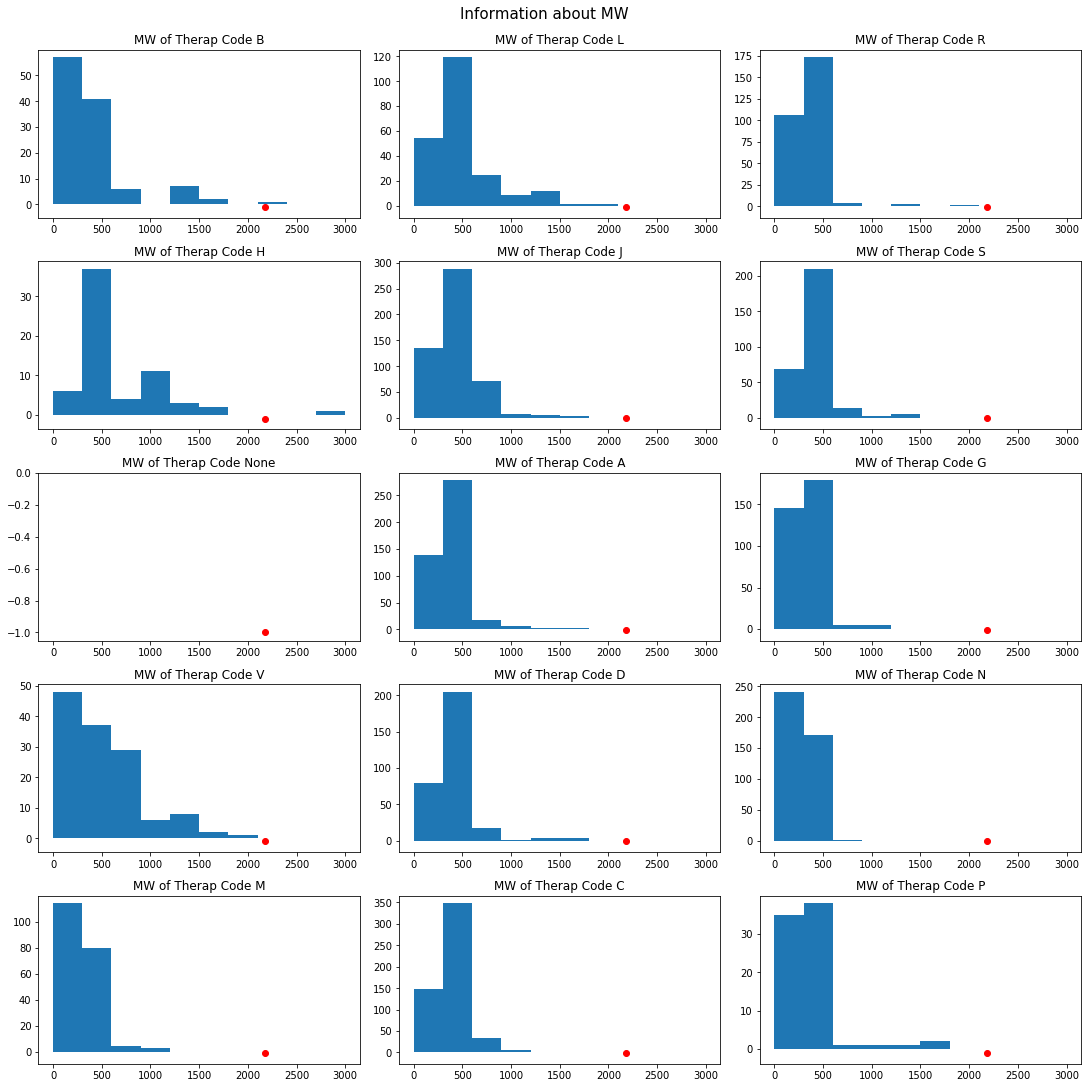

In [69]:
# plot same descriptor, different therapeutic group 
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15), constrained_layout=True)
list_o_axes = axes.flatten()

fig.suptitle("Information about MW", fontsize=15)

i = 0 
for obj in ther_objs:
    ax = list_o_axes[i]
    ther_code = obj.get("ther_code")
    ther_df = obj.get("ther_df")
    plot_df = pd.to_numeric(ther_df["molecular_weight"])
    try: 
        ax.hist(plot_df, 10, range=[0, 3000])
        ax.set_title(f"MW of Therap Code {ther_code}")
        dot_x=[float(compound_data.get("molecular_weight"))]
        dot_y=[-1]
        ax.scatter(dot_x, dot_y, color="red")
        # plot_df.plot.hist(bins=12, alpha=0.5)
    except TypeError as e: 
        print(e)
    i+=1 


plt.show()


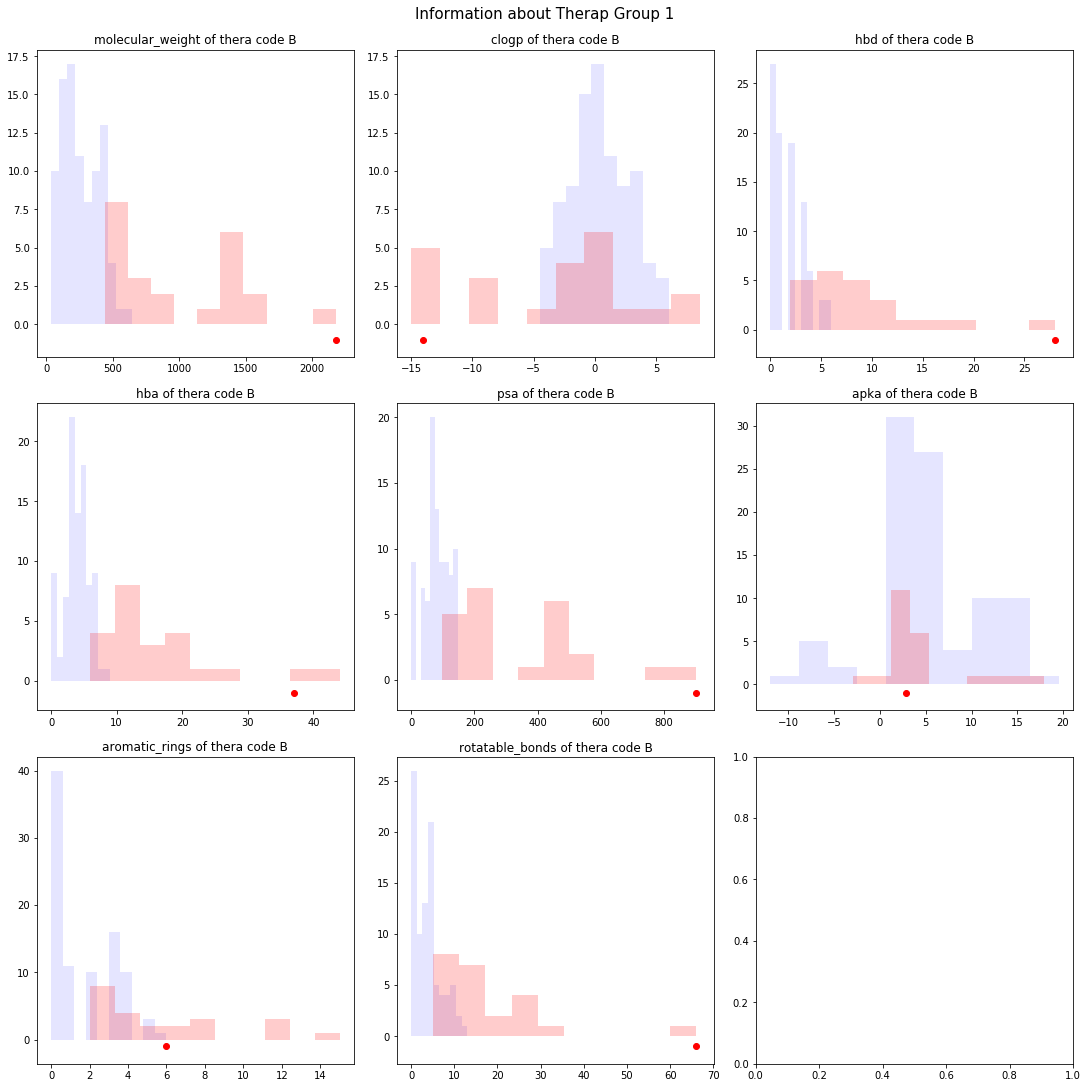

In [81]:
# plot same therapeutic group, different descriptors 
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), constrained_layout=True)
list_o_axes = axes.flatten()

fig.suptitle("Information about Therap Group 1", fontsize=15)

# get a therapeutic group 

ther_obj = ther_objs[0]
ther_df = ther_obj.get("ther_df")
ther_code = ther_obj.get("ther_code")

# prep the compound in question
if compound_data.get("bioavailability") == '1': 
    compound_color = "blue"
else: 
    compound_color = 'red'
    
# create a subplot for that descriptor
i = 0
for descriptor in descriptors: 
    ax = list_o_axes[i]
    plot_df = pd.to_numeric(ther_df[descriptor])
    ba_plot_df = plot_df[ther_df["bioavailability"]=='1']
    nba_plot_df = plot_df[ther_df["bioavailability"]=='0']
    try: 
        ax.hist(ba_plot_df, 10, color='blue', alpha=0.1)
        ax.hist(nba_plot_df, 10, color='red', alpha=0.2)
        dot_x=[float(compound_data.get(descriptor))]
        dot_y=[-1]
        ax.scatter(dot_x, dot_y, color=compound_color)
        ax.set_title(f"{descriptor} of thera code {ther_code}")
    except TypeError as e: 
        print(e)
    i+=1 


plt.show()
    